<a href="https://colab.research.google.com/github/SalhaAlzahrani/DiagnosticMLP/blob/main/Transfomer_vs_DiagnosticMLP_Kidney.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🟨 DiagnosticMLP versus Transfomer Architectures: CT Image classification - Computed Tomography (CT) of the Kidney


In [ ]:
!pip install nest_asyncio
!pip install -U -q tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 12.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_addons as tfa
from keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
import math
import nest_asyncio
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Mounted at /content/drive




---

## 🟡 plot_training_curves

In [ ]:
def plot_training_curves(history, title):
    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])
    epochs = range(len(history.history['loss']))
    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    plt.style.use('bmh') #ggplot #bmh
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2.5))
    fig.patch.set_facecolor('xkcd:white')

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='.', )
    ax1.plot(epochs, val_loss, label='val_loss', marker='.', )
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)
    ax1.set_title('Loss: '+title, fontsize=10)
    ax1.set_xlabel('Epochs', fontsize=10)
    ax1.legend(fontsize=10)

    # Plot accuracy
    ax2.set_ylim(ymin=0, ymax=1.1)
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='.')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='.')
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)
    ax2.set_title('Accuracy: '+title, fontsize=10)
    ax2.set_xlabel('Epochs', fontsize=10)
    ax2.legend(fontsize=10)

## 🟡 Hyperparameters


In [ ]:
path = '/content/drive/MyDrive/_MyResearch_/CT_Datasets/Computed Tomography (CT) of the Kidney/'

image_size = 64 # We'll resize input images to this size.
patch_size = 256
input_shape = (64, 64, 3)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 100
dropout_rate = 0.2
label_smoothing = 0.1

patch_size = 2  # Size of the patches to be extracted from the input images.
num_patches = (input_shape[0] // patch_size) ** 2  # Number of patch
embedding_dim = 64  # Number of hidden units.
mlp_dim = 64
dim_coefficient = 4
num_heads = 4
attention_dropout = 0.2
projection_dropout = 0.2
num_transformer_blocks = 8  # Number of repetitions of the transformer layer

print(f"Image size: {image_size} X {image_size} = {image_size ** 2}")
print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")
print(f"Elements per patch (3 channels): {(patch_size ** 2) * 3}")

Image size: 64 X 64 = 4096
Patch size: 2 X 2 = 4 
Patches per image: 1024
Elements per patch (3 channels): 12


## 🟡 Dataset


In [ ]:
# train data
train_ds = image_dataset_from_directory(
    directory= path,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(image_size, image_size),
    color_mode='rgb',
    seed=128,
    validation_split=0.1,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)
# validation data
val_ds = image_dataset_from_directory(
    directory= path,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(image_size, image_size),
    color_mode='rgb',
    seed=128,
    validation_split=0.1,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 12456 files belonging to 4 classes.
Using 11211 files for training.
Found 12456 files belonging to 4 classes.
Using 1245 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)
##################
num_classes = len(class_names)
##################
num_images_per_class = []
for label in class_names:
    dir_name = path + label
    num_images_per_class.append(len([name for name in os.listdir(dir_name)]))
# y_train=list of train labels wrt to given directory format
y_train=[]
for i in range(0, len(num_images_per_class)):
    y_train+=[i]*num_images_per_class[i]
classes = list()
for i in range(num_classes): classes.append(i)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=np.asarray(y_train))
class_weights_dict = {}
for i in range(len(class_weights)):
   class_weights_dict[i] = class_weights[i]
class_weights_dict

['Cyst', 'Normal', 'Stone', 'Tumor']


{0: 0.8373218607152461,
 1: 0.6133543431160134,
 2: 2.261437908496732,
 3: 1.363994743758213}

In [ ]:
#Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

## 🟡 Experiment
We implement a utility function to compile, train, and evaluate a given model.

In [ ]:
def run_experiment(model):
    # Create Adam optimizer with weight decay.
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay,
    )
    # Compile the model.
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top5-acc"),
            keras.metrics.MeanSquaredError(name='Brier score'),
            keras.metrics.F1Score(name='F1 score'),
            keras.metrics.Recall(name='Recall'),
            keras.metrics.Precision(name='Precision'),
            keras.metrics.AUC(name='AUC'),
        ],
    )
    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5
    )
    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        train_ds,
        validation_data = val_ds,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        class_weight=class_weights_dict,
        callbacks=[early_stopping, reduce_lr],
    )
    # Return history to plot learning curves.
    return history

## 🟡 Augmentation


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip('horizontal_and_vertical'),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
        layers.RandomContrast(factor=0.2),
        layers.RandomCrop(height=image_size, width=image_size),
        layers.RandomBrightness(factor=0.2),
    ],
    name="data_augmentation",
)



---



# Implement the patch extraction and encoding layer


In [ ]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size, self.patch_size, 1),
            strides=(1, self.patch_size, self.patch_size, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)


# Implement the external attention block


In [ ]:
def external_attention(
    x, dim, num_heads, dim_coefficient=4, attention_dropout=0, projection_dropout=0
):
    _, num_patch, channel = x.shape
    assert dim % num_heads == 0
    num_heads = num_heads * dim_coefficient

    x = layers.Dense(dim * dim_coefficient)(x)
    # create tensor [batch_size, num_patches, num_heads, dim*dim_coefficient//num_heads]
    x = tf.reshape(
        x, shape=(-1, num_patch, num_heads, dim * dim_coefficient // num_heads)
    )
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    # a linear layer M_k
    attn = layers.Dense(dim // dim_coefficient)(x)
    # normalize attention map
    attn = layers.Softmax(axis=2)(attn)
    # dobule-normalization
    attn = attn / (1e-9 + tf.reduce_sum(attn, axis=-1, keepdims=True))
    attn = layers.Dropout(attention_dropout)(attn)
    # a linear layer M_v
    x = layers.Dense(dim * dim_coefficient // num_heads)(attn)
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    x = tf.reshape(x, [-1, num_patch, dim * dim_coefficient])
    # a linear layer to project original dim
    x = layers.Dense(dim)(x)
    x = layers.Dropout(projection_dropout)(x)
    return x

# Implement the MLP block


In [ ]:
def mlp(x, embedding_dim, mlp_dim, drop_rate=0.2):
    x = layers.Dense(mlp_dim, activation=tf.nn.gelu)(x)
    x = layers.Dropout(drop_rate)(x)
    x = layers.Dense(embedding_dim)(x)
    x = layers.Dropout(drop_rate)(x)
    return x

# Implement the Transformer block


In [ ]:
def transformer_encoder(
    x,
    embedding_dim,
    mlp_dim,
    num_heads,
    dim_coefficient,
    attention_dropout,
    projection_dropout,
    attention_type="external_attention",
):
    residual_1 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    if attention_type == "external_attention":
        x = external_attention(
            x,
            embedding_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
        )
    elif attention_type == "self_attention":
        x = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embedding_dim, dropout=attention_dropout
        )(x, x)
    x = layers.add([x, residual_1])
    residual_2 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    x = mlp(x, embedding_dim, mlp_dim)
    x = layers.add([x, residual_2])
    return x

# Implement the Self-Attention and External Attention (ENet) model


In [ ]:
def get_model(attention_type="external_attention"):
    inputs = layers.Input(shape=input_shape)
    # Image augment
    x = data_augmentation(inputs)
    #x = inputs
    # Extract patches.
    x = PatchExtract(patch_size)(x)
    # Create patch embedding.
    x = PatchEmbedding(num_patches, embedding_dim)(x)
    # Create Transformer block.
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(
            x,
            embedding_dim,
            mlp_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
            attention_type,
        )

    x = layers.GlobalAvgPool1D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

## 🔷 Self-Attention

In [ ]:
model_SA = get_model(attention_type="self_attention")
model_SA.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 data_augmentation (Sequent  (None, 64, 64, 3)            7         ['input_1[0][0]']             
 ial)                                                                                             
                                                                                                  
 patch_extract (PatchExtrac  (None, 1024, 12)             0         ['data_augmentation[0][0]']   
 t)                                                                                               
                                                                                              

In [ ]:
history_SA = run_experiment(model_SA)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


351/351 [==============================] - 882s 2s/step - loss: 2.3471 - accuracy: 0.3571 - top5-acc: 1.0000 - Brier score: 0.2113 - F1 score: 0.3246 - Recall: 0.2291 - Precision: 0.3771 - AUC: 0.6101 - val_loss: 1.1989 - val_accuracy: 0.4755 - val_top5-acc: 1.0000 - val_Brier score: 0.1612 - val_F1 score: 0.3168 - val_Recall: 0.3486 - val_Precision: 0.6121 - val_AUC: 0.7376 - lr: 0.0010
Epoch 2/100
351/351 [==============================] - 57s 162ms/step - loss: 1.5880 - accuracy: 0.4094 - top5-acc: 1.0000 - Brier score: 0.1896 - F1 score: 0.3636 - Recall: 0.2592 - Precision: 0.4630 - AUC: 0.6558 - val_loss: 1.3462 - val_accuracy: 0.4458 - val_top5-acc: 1.0000 - val_Brier score: 0.1700 - val_F1 score: 0.2742 - val_Recall: 0.3799 - val_Precision: 0.5685 - val_AUC: 0.7229 - lr: 0.0010
Epoch 3/100
351/351 [==============================] - 57s 162ms/step - loss: 1.4707 - accuracy: 0.4265 - top5-acc: 1.0000 - Brier score: 0.1798 - F1 score: 0.3807 - Recall: 0.2819 - Precision: 0.5062 - A

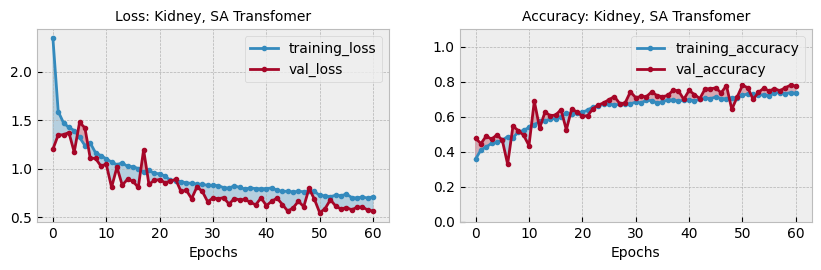

In [ ]:
plot_training_curves(history_SA, 'Kidney, SA Transfomer')



---


## 🔷 External-Attention

In [ ]:
model_EA = get_model(attention_type="external_attention")
model_EA.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 data_augmentation (Sequent  (None, 64, 64, 3)            7         ['input_2[0][0]']             
 ial)                                                                                             
                                                                                                  
 patch_extract_1 (PatchExtr  (None, 1024, 12)             0         ['data_augmentation[1][0]']   
 act)                                                                                             
                                                                                            

In [ ]:
history_EA = run_experiment(model_EA)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


351/351 [==============================] - 41s 82ms/step - loss: 3.1666 - accuracy: 0.3510 - top5-acc: 1.0000 - Brier score: 0.2206 - F1 score: 0.3217 - Recall: 0.2490 - Precision: 0.3708 - AUC: 0.6000 - val_loss: 1.4809 - val_accuracy: 0.2980 - val_top5-acc: 1.0000 - val_Brier score: 0.2016 - val_F1 score: 0.2026 - val_Recall: 0.2257 - val_Precision: 0.3279 - val_AUC: 0.6345 - lr: 0.0010
Epoch 2/100
351/351 [==============================] - 27s 76ms/step - loss: 1.4676 - accuracy: 0.3817 - top5-acc: 1.0000 - Brier score: 0.1862 - F1 score: 0.3450 - Recall: 0.1995 - Precision: 0.4434 - AUC: 0.6477 - val_loss: 1.4465 - val_accuracy: 0.4217 - val_top5-acc: 1.0000 - val_Brier score: 0.1831 - val_F1 score: 0.2063 - val_Recall: 0.3751 - val_Precision: 0.5289 - val_AUC: 0.6957 - lr: 0.0010
Epoch 3/100
351/351 [==============================] - 27s 76ms/step - loss: 1.6076 - accuracy: 0.3930 - top5-acc: 1.0000 - Brier score: 0.1930 - F1 score: 0.3541 - Recall: 0.2601 - Precision: 0.4381 - AU

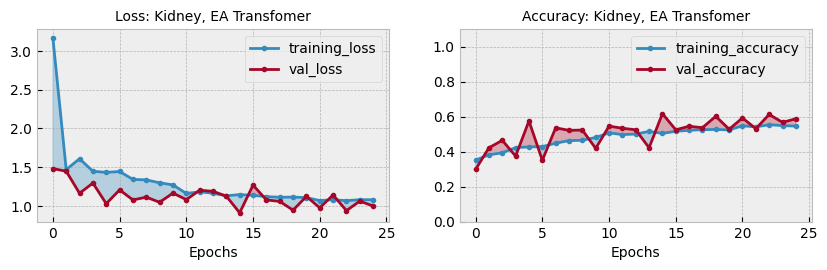

In [ ]:
plot_training_curves(history_EA, 'Kidney, EA Transfomer')